# Convergence of Syntactic Complexity in Conversation

Research based on 'Convergence of Syntactic Complexity in Conversation' by Yang Xu and David Reitter, 2016.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import sys
from collections import defaultdict
from scipy.stats import binned_statistic

In [2]:
from swda_time import CorpusReader
corpus = CorpusReader('swda_time', 'swda_time/swda-metadata-ext.csv')

In [3]:
ttt = nltk.tokenize.TextTilingTokenizer()

## UtteranceWrapper class

Wrapper for collected utterance data

In [4]:
class UtteranceWrapper:
    def __init__(self, speaker, text, length, depth, width):
        self.speaker = speaker
        self.text = text
        self.length = length
        self.depth = depth
        self.width = width
        self.ntd = None
        self.ntw = None
        
    def set_ntd(self, ntd_const):
        self.ntd = self.depth / float(ntd_const)
        
    def set_ntw(self, ntw_const):
        self.ntw = self.width / float(ntw_const)
        
    def get_all_measures(self):
        return [self.length, self.depth, self.width, self.ntd, self.ntw]
    
    def get_array(self):
        return np.asarray(self.get_all_measures())

## Collect speaker data

In [5]:
COLLECTOR_VERBOSE = False

def collect_transcript_data():
    """
    Collects a list of lists that cotains the utterance wrappers for all transcripts in the SWDA time dataset
    :return: a list of lists that cotains the utterance wrappers for all transcripts in the SWDA time dataset
    """
    transcripts_list = []
    for transcript in corpus.iter_transcripts(display_progress=True):
        conversation_list = []
        for utterance in transcript.utterances:

    #         sub_utterance = utterance.subutterance_index
    #         print(sub_utterance)

            speaker = utterance.caller
            if COLLECTOR_VERBOSE: print(speaker)
            text = utterance.pos_words()
            if COLLECTOR_VERBOSE: print(text)
            if utterance.trees:         
                # TODO: Currently only considering the first tree # # # # # # # # #
                tree = utterance.trees[0] 
            else:
                # TODO: Handle cases where no tree is found # # # # # # # # # # # # 
                
                # print("WARNING: Utterance {} has no tree!".format(utterance.pos_words()))
                # This only prints full stops
                continue
            
            if COLLECTOR_VERBOSE: tree.pretty_print()
            subtrees = tree.subtrees()

            # Collect syntactic complexity metrics
            # Sentence length
            sentence_length = len(text)
            if COLLECTOR_VERBOSE: print(sentence_length)

            # Tree depth
            tree_depth = tree.height()
            if COLLECTOR_VERBOSE: print(tree_depth)

            node_count = 0
            branching_sum = 0        
            # Branching factor        
            for t in subtrees: 
                if COLLECTOR_VERBOSE: print(t)
                num_children = len(t.leaves())
                if COLLECTOR_VERBOSE: print(num_children)
                node_count += 1
                branching_sum += num_children

            tree_width = branching_sum / float(node_count)
            if COLLECTOR_VERBOSE: print(tree_width)

    #         pos = utterance.pos_lemmas()
    #         print(pos)

            wrapper = UtteranceWrapper(speaker, text, sentence_length, tree_depth, tree_width)
            conversation_list.append(wrapper)
        transcripts_list.append(conversation_list)
        
    return transcripts_list

In [6]:
transcripts_list = collect_transcript_data()

transcript 645


## Calculate normalized measures from collected data

In [7]:
def collect_normalized_data(transcripts_list):
    """
    Calculates normalized tree depth and width by iterating through the collected transcript list 
    and averaging over the recorded numbers
    :param transcripts_list: A list of lists containing utterance wrappers
    :return: Nothing
    """
    length_sum = 0
    depth_sum = 0
    width_sum = 0

    depth_normalizer_dict = defaultdict(lambda: list())
    width_normalizer_dict = defaultdict(lambda: list())
    
    for t, wrapper_list in enumerate(transcripts_list):
        for i, wrapper in enumerate(wrapper_list):
            length = wrapper.length
            depth = wrapper.depth
            width = wrapper.width

            if t % 100 == 0 and i % 100 == 0:
                print("Utterance {}: Length {} - Depth {} - Width {}".format(i, length, depth, width))

            length_sum += length
            depth_sum += depth
            width_sum += width

            depth_normalizer_dict[length].append(depth)
            width_normalizer_dict[length].append(width)
            
    depth_normalizer_const = dict()
    width_normalizer_const = dict()

    for key, depth_list in depth_normalizer_dict.items():
        depth_normalizer_const[key] = np.average(depth_list)
    for key, width_list in width_normalizer_dict.items():
        width_normalizer_const[key] = np.average(width_list)

#     for key in depth_normalizer_dict.keys():
#         print("Normalizing constants for length {}: Depth {} - Width {}".format(key, depth_normalizer_const[key], width_normalizer_const[key]))

    for t, wrapper_list in enumerate(transcripts_list):
        for i, wrapper in enumerate(wrapper_list):
            key = wrapper.length
            wrapper.set_ntd(depth_normalizer_const[key])
            wrapper.set_ntw(width_normalizer_const[key])
            
            if t % 100 == 0 and i % 100 == 0:
                print("Utterance {}: Normalized Depth {} - Normalized Width {}".format(i, wrapper.ntd, wrapper.ntw))

In [8]:
collect_normalized_data(transcripts_list)

Utterance 0: Length 2 - Depth 3 - Width 1.5
Utterance 100: Length 3 - Depth 4 - Width 1.42857142857
Utterance 200: Length 2 - Depth 3 - Width 1.5
Utterance 0: Length 2 - Depth 3 - Width 1.5
Utterance 100: Length 2 - Depth 3 - Width 1.5
Utterance 0: Length 2 - Depth 4 - Width 1.42857142857
Utterance 100: Length 13 - Depth 12 - Width 2.84375
Utterance 0: Length 2 - Depth 3 - Width 1.5
Utterance 100: Length 5 - Depth 5 - Width 1.83333333333
Utterance 200: Length 2 - Depth 3 - Width 1.5
Utterance 0: Length 11 - Depth 9 - Width 2.39285714286
Utterance 100: Length 6 - Depth 6 - Width 1.66666666667
Utterance 0: Length 9 - Depth 5 - Width 1.6875
Utterance 100: Length 31 - Depth 10 - Width 2.90361445783
Utterance 0: Length 2 - Depth 3 - Width 1.5
Utterance 100: Length 12 - Depth 16 - Width 4.70588235294
Utterance 0: Normalized Depth 0.923368569553 - Normalized Width 0.973457715677
Utterance 100: Normalized Depth 0.762731938413 - Normalized Width 0.798988919091
Utterance 200: Normalized Depth 0.

## Chunk the data to display measures through the course of a dialogue/topic

In [9]:
def chunk(seq, num_bins):
    """
    Splits or replicates the data to fill a given number of bins
    :param seq: List of elements to be split
    :param num_bins: Number of bins to be filled
    :return: List of lists containing the chunks
    """    
    # If sequence length is higher than the bin count: Chunk
    if len(seq) > num_bins:   
        k, m = divmod(len(seq), num_bins)
        chunks = list((seq[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in xrange(num_bins)))
        assert len(chunks) == num_bins
        return chunks
    # Else: Replicate some of the data to strech it into the bins
    else:
        chunks = [None] * num_bins
        avg = num_bins / float(len(seq))
        last = 0.0
        for item in seq:
            indeces = range(int(last), int(last + avg))
            for i in indeces:
                chunks[i] = item
            last += avg
        if not chunks[-1]: chunks[-1] = seq[-1] 
        assert len(chunks) == num_bins
        return chunks      

In [10]:
def get_chunk_means(seq, num_bins):
    """
    Calculates the means of a given list of items, split into num_bins 
    :param seq: A list of measurements
    :param num_bins: Number of bins to split the data in
    :return: List of num_bins means of sequence seq
    """
    chunks = chunk(seq, num_bins)
#     print(chunks)
    means = [np.mean(c) for c in chunks]
    return means

In [11]:
def collect_speaker_data(wrappers, num_bins):
    """
    Collects mean complexity measures over time for all speakers 
    :param wrappers: A list of wrappers to be processed
    :param num_bins: Number of bins to split the data in (time steps)
    :return: A dictionary indexed by speaker containing dictionaries indexed by measurement
    """
    data = defaultdict(lambda: list())
    [data[wrapper.speaker].append(wrapper.get_all_measures()) for wrapper in wrappers]
    
    chunk_means = defaultdict(lambda: defaultdict(lambda: list()))   
    for speaker, speaker_data in data.items():
        data_array = np.asarray(speaker_data)
#         print("Speaker {}: {} utterance(s)".format(speaker, len(data_array)))
#         print(data_array.T)
        
        for m, column in enumerate(data_array.T):  
            chunk_means[speaker][m] = get_chunk_means(column, num_bins)
    return chunk_means

In [12]:
def get_measure_name(measure):
    """
    Returns the string name of a measurement
    :param measure: integer index of a measurement
    :return: the string name of a measurement
    """
    if measure == 0:
        return "Sentence Length"
    elif measure == 1:
        return "Tree Depth"
    elif measure == 2:
        return "Tree Width"
    elif measure == 3:
        return "Normalized Tree Depth"
    elif measure == 4:
        return "Normalized Tree Width"

def plot_speaker_data(chunk_means, measure):
    """
    Plots a given measure for all speakers given the data collected in chunk_means
    :param chunk_means: Collected data for a dialogue/topic
    :param measure: integer index of the measure to be displayed
    :return: Nothing
    """
    legend_text = []
    means_list = []
    for speaker in chunk_means.keys():        
        legend_text.append("Speaker " + speaker)
        means_list.append(chunk_means[speaker][measure])
                 
#     differences = np.abs(np.subtract(np.asarray(means_list[0]), np.asarray(means_list[1])))
#     legend_text.append("Differences")
#     means_list.append(list(differences))
    for items in means_list: plt.plot(items)    
    plt.ylabel(get_measure_name(measure))
    plt.xlabel('Within-conversation position of sentence')
    plt.title("Comparison of " + get_measure_name(measure))
    plt.legend(legend_text)
    plt.show()
    
def plot_speaker_differences(overall_means, measure):
    """
    Only plots measurement differences between two speakers
    :param overall_means: Collected data for a dialogue/topic
    :param measure: integer index of the measure to be displayed
    :return: Nothing
    """
    means_list = []
    for speaker in overall_means.keys():        
        means_list.append(overall_means[speaker][measure])
    differences = np.abs(np.subtract(np.asarray(means_list[0]), np.asarray(means_list[1])))
    legend_text = ["Differences"]
    plt.plot(list(differences))    
    plt.ylabel(get_measure_name(measure))
    plt.xlabel('Within-conversation position of sentence')
    plt.title("Comparison of " + get_measure_name(measure))
    plt.legend(legend_text)
    plt.show()

## Show the comparison of measurements over time

In [13]:
def collect_overall_means(chunk_means):
    """
    Calculates the averages over data collected in a list of speaker->measurement->measures dictionaries
    :param chunk_means: a list of speaker->measurement->measures dictionaries
    :return: a speaker->measurement->measures dictionary of averages calculated from the input list
    """
    overall_sums = defaultdict(lambda: defaultdict(lambda: list()))
    for means in chunk_means:
        for s, measures in means.items():
            for m, v in measures.items():
                overall_sums[s][m].append(v)

    overall_means = dict()
    for s, measures in overall_sums.items():
        mean_speaker_data = dict()
        for m, data in measures.items():
            mean_speaker_data[m] = np.mean(data, axis = 0)
        overall_means[s] = mean_speaker_data
    
    return overall_means

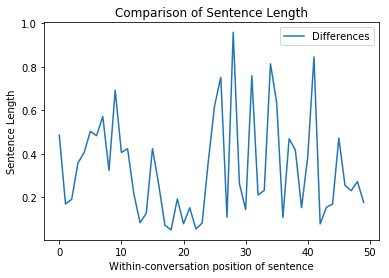

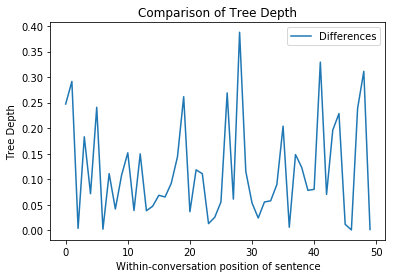

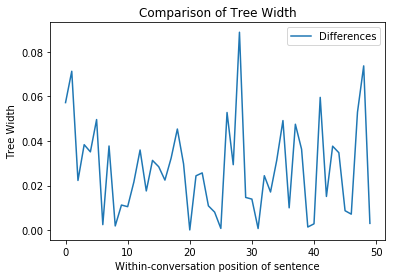

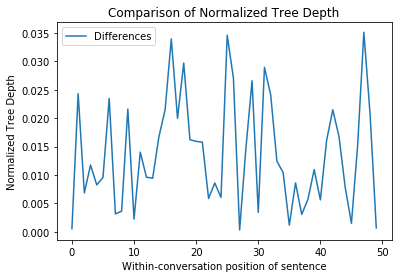

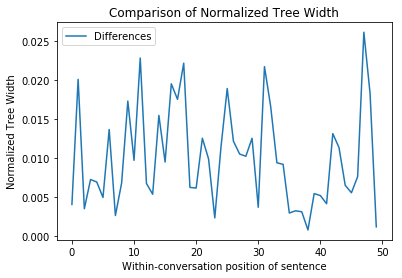

In [14]:
chunk_means = []

for transcript in transcripts_list:
    chunk_means.append(collect_speaker_data(wrappers = transcript, num_bins = 50))
    
overall_means = collect_overall_means(chunk_means)
for measure in range(5):
    plot_speaker_differences(overall_means, measure)

## Topic segmentation with TextTiling

In [15]:
def get_transcript_texts():
    """
    Collects the text-only transcripts of the SWDA time corpus, 
    represented as lists of utterances by the different speakers over time
    :return: A list of text-only transcripts of the SWDA time corpus 
    """
    transcript_texts = []
    for transcript in corpus.iter_transcripts(display_progress=True):
        conversation_text = ""
        last_turn_index = 1
        for utterance in transcript.utterances:
            current_turn_id = utterance.turn_index
            if current_turn_id != last_turn_index:
                conversation_text += "\n\n\n\t"
            conversation_text += " " + " ".join(utterance.pos_words())
            last_turn_index = current_turn_id
        conversation_text += "\n\n\n\t"
        transcript_texts.append(conversation_text)

    return transcript_texts

In [16]:
def tt_get_topic_start_indexes(tiles, transcript_data):
    """
    Given tiles produced by a topic segmentation algorithm, determine the utterance indexes of the splits
    :param tiles: Tiles produced by a topic segmentation algorithm
    :param transcript_data: A list of utterance wrappers collected for the given transcript
    :return: A list of indexes of the topic splits in the original transcript
    """
    topic_start_indexes = []
    tile_index = 0
    tile_length = len(tiles[tile_index].replace('\n\n\n\t', "").strip().split(" "))
    
    block_length = 0
    last_index = 0
    for i, wrapper in enumerate(transcript_data):
        block_length += wrapper.length
        
#         print(tile_length, block_length)    
#         print("- - T: {}".format(tiles[tile_index].replace('\n\n\n\t', "").strip().split(" ")))
#         block_text = []
#         for wrapper in transcript_data[last_index:i]:
#             block_text.extend(wrapper.text)
#         print("- - B: {}".format(block_text))

        if block_length == tile_length:
            topic_start_indexes.append(i)
            block_length = 0
            tile_index += 1

            
            if tile_index < len(tiles):
                tile_length = len(tiles[tile_index].replace('\n\n\n\t', "").strip().split(" "))
                last_index = i
           
    return topic_start_indexes

## Topic Shift prediction model

In [17]:
def get_next_topic_break(transcript_wrapper, last_index, features, weights, threshold):
    MODEL_VERBOSE = False
    
    topic_leader = None
    for i in range(last_index+1, len(transcript_wrapper)):
        utterance = transcript_wrapper[i]
        if MODEL_VERBOSE: print(utterance.text)
        if utterance.length >= 5:
            topic_leader = utterance.speaker
            last_index = i
            break
    if not topic_leader:
        return None
    
#     print(transcript_wrapper[i].text)
#     print(transcript_wrapper[i].get_array())
    leader_measures = [transcript_wrapper[i].get_array()]
    follower_measures = []
    
    for i in range(last_index+1, len(transcript_wrapper)):
        
        if MODEL_VERBOSE: print("--- Utterance", str(i))
        utterance = transcript_wrapper[i]
#         print(i)
        if MODEL_VERBOSE: print(" ".join(transcript_wrapper[i].text))
#         print(transcript_wrapper[i].get_array())
        if utterance.length < 3: 
            continue
        if utterance.speaker == topic_leader:
            if MODEL_VERBOSE: print("Adding leader data")
            leader_measures.append(transcript_wrapper[i].get_array())
        else:
            if MODEL_VERBOSE: print("Adding follower data")
            follower_measures.append(transcript_wrapper[i].get_array())
            
        # TODO: Determine minimum topic length
        # Compare measures
        if follower_measures:
            init_distances = leader_measures[0] - follower_measures[0]
            current_distance = leader_measures[-1] - follower_measures[-1]
            
            leader_distance = leader_measures[0] - leader_measures[-1]
            follower_distance = follower_measures[0] - follower_measures[-1]
            
#             print("Current measures")
#             print(leader_measures[-1])
#             print(follower_measures[-1])
            
            if MODEL_VERBOSE: print("Distances")
            if MODEL_VERBOSE: print(init_distances)
            if MODEL_VERBOSE: print(current_distance)
#             print(leader_distance)
#             print(follower_distance)
            
            distance_development = np.divide((init_distances - current_distance), init_distances)
            leader_development = np.divide(leader_distance, leader_measures[0])
            follower_development = np.divide(follower_distance, follower_measures[0])
            
            if MODEL_VERBOSE: print("Development")
            if MODEL_VERBOSE: print(distance_development)
                
            if 1 in features:
                topic_score = np.sum(distance_development * weights)
                if MODEL_VERBOSE: print(topic_score)            
                if topic_score > threshold:
                    return i
            else:
                topic_score = np.sum(distance_development * weights)
                if MODEL_VERBOSE: print(topic_score)            
                if topic_score > threshold:
                    return i
            
    return None

def model_get_topic_start_indexes(transcript_wrapper, features, weights, threshold):
    # Determine first topic initator
    MODEL_VERBOSE = False
    
    topic_shifts = [0]
    last_index = 0  
    
    while True:
        next_shift = get_next_topic_break(transcript_wrapper, last_index, features, weights, threshold)
        
        if next_shift:
            if MODEL_VERBOSE: print("Topic shift at " + str(next_shift))
            topic_shifts.append(next_shift)
            last_index = next_shift
        else:
            break
    
                
#             print(leader_development)
#             print(follower_development)
            
#             if len(leader_measures)>3 and len(follower_measures)>3:
#                 distance_local = leader_measures[-1] - follower_measures[-1] - (np.mean(leader_measures[-4:-1] \
#                                                                                       - np.mean(follower_measures[-4:-1])))
#                 leader_local = leader_measures[-1] - np.mean(leader_measures[-4:-1])
#                 follower_local = follower_measures[-1] - np.mean(follower_measures[-4:-1])
                                                                              
#                 local_distance_development = np.divide(distance_local, leader_measures[-1] - follower_measures[-1])
#                 local_leader_development = np.divide(leader_local, leader_measures[0]) 
#                 local_follower_development = np.divide(follower_local, follower_measures[0])
                
#                 print("Local Development")
#                 print(local_distance_development)
#                 print(local_leader_development)
#                 print(local_follower_development)
#             sys.exit(1)

    if MODEL_VERBOSE: print("{} topic shifts: {}".format(len(topic_shifts), topic_shifts))
    return(topic_shifts)
            
# model_get_transcript_indexes(transcripts_list[0])
        
#     if ROLES_VERBOSE: print("Leader is {}".format(topic_leader))
#     try:
#         speaker_data['Leader'] = speaker_data.pop(topic_leader)
#     except KeyError: 
#         print(speaker_data)
#     for key in speaker_data.keys():
#         if key != 'Leader':
#             speaker_data['Follower'] = speaker_data.pop(key)

In [18]:
transcript_texts = get_transcript_texts()

transcript 645


In [67]:
def save_tiles(transcript, topic_start_indexes, index, method):
    conversation = ""
    counter = 1
    for i, utterance in enumerate(transcript):
        if i in topic_start_indexes:
            conversation += "\n----- Topic " + str(counter) + " start at " + str(i) + " -----\n"
            counter += 1
        conversation += utterance.speaker + ": " + " ".join(utterance.text) + "\n"
    
    if method == 'texttiling':
        fname = "conversation" + str(index) + "_tt.txt"
    elif method == 'model': 
        fname = "conversation" + str(index) + "_model.txt"
    elif method == 'random': 
        fname = "conversation" + str(index) + "_random.txt"
    else:
        print('ERROR: UNKNOWN METHOD')
        sys.exit(1)
        
    with open(fname, 'w') as file:
        file.write(conversation)
        
        
def save_tiles_taaco(transcript, topic_start_indexes, index, method):
    conversation = ""
    for i, utterance in enumerate(transcript):
        if i in topic_start_indexes:
            conversation += "\n\n"
        conversation += " ".join(utterance.text) + " "
        
    fname = "taaco_transcripts/{}/transcript_{}.txt".format(method, index)
    with open(fname, 'w') as file:
        file.write(conversation)

        
def collect_topic_data(topic_index_list, transcripts_list, transcript_texts, method, collapse=True, save_flag=False, num_bins = 10):
    """
    Collects the average speaker complexity measures over a collected set of transcripts
    :param transcript_texts: A list of text-only transcripts 
    :param transcripts_list: A list of lists containing the utterance wrappers collected for the given transcripts
    :param num_bins: The number of bins to split the data in (time steps)
    :return: 
    """
    ROLES_VERBOSE = False
    
    assert len(topic_index_list) == len(transcripts_list) == len(transcript_texts)
    
    invalid_counter = 0
    
    overall_means = []
    for i in range(len(topic_index_list)):
        topic_start_indexes = topic_index_list[i]
        transcript = transcripts_list[i]
        text = transcript_texts[i]
        
#         if i == 0: ROLES_VERBOSE = True
        sys.stderr.write("\r")
        sys.stderr.write("transcript %s" % i)
        sys.stderr.flush()

        if not topic_start_indexes:
            invalid_counter += 1
            continue
    
        if save_flag and i % 100 == 0: save_tiles(transcripts_list[i], topic_start_indexes, i, method)
        if save_flag: save_tiles_taaco(transcripts_list[i], topic_start_indexes, i, method)

        tile_counter = 1
        last_index = topic_start_indexes[0]
        last_speaker = transcript[last_index].speaker
        
        chunk_means = []
        for i in topic_start_indexes[1:]:
            if ROLES_VERBOSE: print("Topic segment {}: Utterances {} through {}".format(tile_counter, last_index, i-1))
            wrappers = transcript[last_index:i]    
            
            if ROLES_VERBOSE: print(wrappers[0].text)
            
            speaker_data = collect_speaker_data(wrappers, num_bins)
        
            # Determine the speaker roles in the topic
            topic_initiator = transcript[last_index].speaker
            if ROLES_VERBOSE: print("First speaker is {}".format(topic_initiator))
            
            if topic_initiator == last_speaker:
                topic_leader = topic_initiator
            else:
                for wrapper in transcript[last_index:i]:
                    if wrapper.length >= 5:
                        topic_leader = wrapper.speaker
                        break
            assert topic_leader 
            
            if ROLES_VERBOSE: print("Leader is {}".format(topic_leader))
            try:
                speaker_data['Leader'] = speaker_data.pop(topic_leader)
            except KeyError: 
                print('WARNING: Key error!')
            for key in speaker_data.keys():
                if key != 'Leader':
                    speaker_data['Follower'] = speaker_data.pop(key)
           
            chunk_means.append(speaker_data)         
            tile_counter += 1
            last_index = i
            last_speaker = transcript[i-1].speaker
            
            if ROLES_VERBOSE: print("Last speaker is {}".format(last_speaker))
            
        if collapse:
            overall_means.append(collect_overall_means(chunk_means))
        else:
            overall_means.append(chunk_means)
        
    if method == 'texttiling': print(str(invalid_counter) + ' transcripts returned no topics in TextTiling')
    if method == 'random': print(str(invalid_counter) + ' transcripts returned no topics in Random')
    return overall_means    

In [20]:
def get_model_topic_indexes(transcripts_list, features, weights, threshold):
    model_topic_start_indexes = []
    for i, transcript in enumerate(transcripts_list):
        sys.stderr.write("\r")
        sys.stderr.write("transcript %s" % i)
        sys.stderr.flush()
        model_topic_start_indexes.append(model_get_topic_start_indexes(transcript, features, weights, threshold))
        
    return model_topic_start_indexes

def get_tt_topic_indexes(transcripts_list, transcript_texts):
    tt_topic_start_indexes = []
    for i, text in enumerate(transcript_texts):
        sys.stderr.write("\r")
        sys.stderr.write("transcript %s" % i)
        sys.stderr.flush()
        
        tiles = ttt.tokenize(text)        
        tt_topic_start_indexes.append(tt_get_topic_start_indexes(tiles, transcripts_list[i]))
        
    return tt_topic_start_indexes

def compare_topic_start_indexes(tt_topic_start_indexes, model_topic_start_indexes, diff_weight=20):
    c_distance = 0
    tt_topics = []
    model_topics = []
    for tt_indexes, model_indexes in zip(tt_topic_start_indexes, model_topic_start_indexes):
        if len(tt_indexes)>1:
            t_distance = 0
            for tt_index in tt_indexes:
                best = min(model_indexes, key=lambda x:abs(x-tt_index))
                t_distance += (tt_index - best)**2
            # print('Transcript distance: ' + str(t_distance))
            c_distance += (t_distance + diff_weight * (len(tt_indexes) - len(model_indexes))**2) / float(len(tt_indexes))
            tt_topics.append(len(tt_indexes))
            model_topics.append(len(model_indexes))
            # print('TextTiling: {} topics, Model: {} topics'.format(len(tt_indexes), len(model_indexes)))
        
    print('Total distance: ' + str(c_distance))
    print('Average distance per transcript: ' + str(c_distance / float(len(tt_topic_start_indexes))))
    print('TextTiling: {} topics, Model: {} topics per transcript'.format(np.mean(tt_topics), np.mean(model_topics)))

In [21]:
def get_random_topic_indexes(transcripts_list, topic_length):
    topic_start_indexes = []
    for transcript in transcripts_list:
        length = len(transcript)
        number = int(length / float(topic_length))
        topic_start_indexes.append(list(np.random.choice(length, number)))
    return topic_start_indexes

In [22]:
tt_topic_start_indexes = get_tt_topic_indexes(transcripts_list, transcript_texts)

transcript 641

In [57]:
features = [1]

threshold = 5
weights = np.asarray([1 , 0.25, 0.25, 1, 1])
model_topic_start_indexes = get_model_topic_indexes(transcripts_list, features, weights, threshold)
# print(type(model_topic_start_indexes))
# print(type(model_topic_start_indexes[0]))

transcript 1/home/janosch/anaconda3/envs/tfenv2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in divide
/home/janosch/anaconda3/envs/tfenv2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in divide
transcript 641

In [58]:
random_topic_length = 23
random_topic_start_indexes = get_random_topic_indexes(transcripts_list, random_topic_length)
# print(type(random_topic_start_indexes))
# print(type(random_topic_start_indexes[0]))

In [25]:
diff_weight = 1
compare_topic_start_indexes(tt_topic_start_indexes, model_topic_start_indexes, diff_weight)

Total distance: 49051.3941894
Average distance per transcript: 76.4040407934
TextTiling: 7.43605870021 topics, Model: 12.748427673 topics per transcript


In [26]:
diff_weight = 1
compare_topic_start_indexes(tt_topic_start_indexes, random_topic_start_indexes, diff_weight)

Total distance: 135200.240964
Average distance per transcript: 210.592275645
TextTiling: 7.43605870021 topics, Model: 7.37945492662 topics per transcript


## Analysis of topic shift points

In [68]:
overall_means_tt = collect_topic_data(tt_topic_start_indexes, transcripts_list, transcript_texts, method='texttiling', save_flag=True)

transcript 641

83 transcripts returned no topics in TextTiling


In [69]:
overall_means_model = collect_topic_data(model_topic_start_indexes, transcripts_list, transcript_texts, method='model', save_flag=True)

transcript 641

In [70]:
overall_means_random = collect_topic_data(random_topic_start_indexes, transcripts_list, transcript_texts, method='random', save_flag=True)

transcript 38

transcript 70

transcript 100

transcript 138

transcript 165

transcript 194

transcript 224

transcript 255

transcript 291

transcript 337

transcript 389

transcript 441

transcript 493

transcript 549

transcript 607

transcript 641

0 transcripts returned no topics in Random


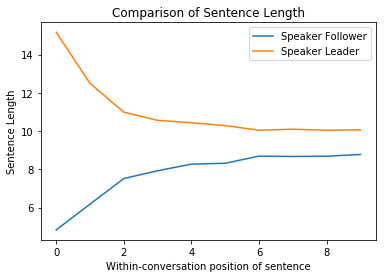

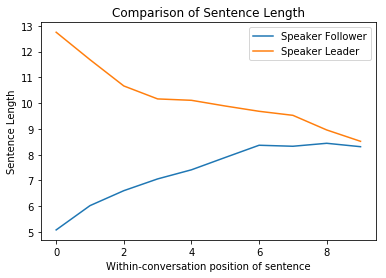

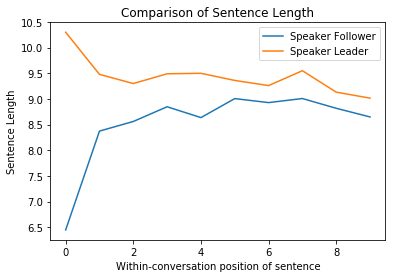

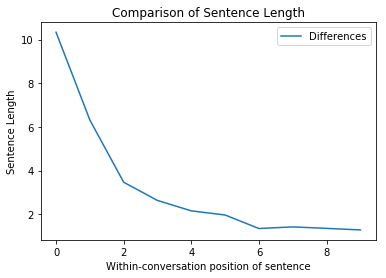

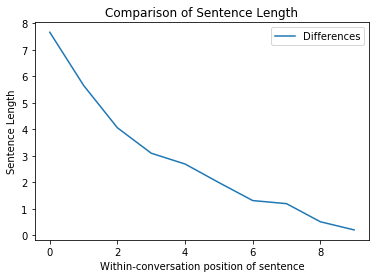

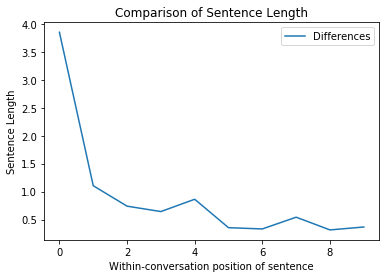

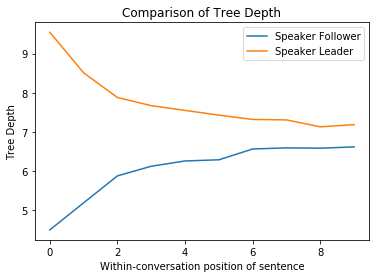

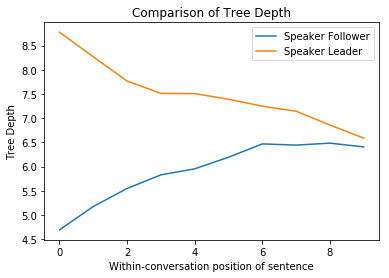

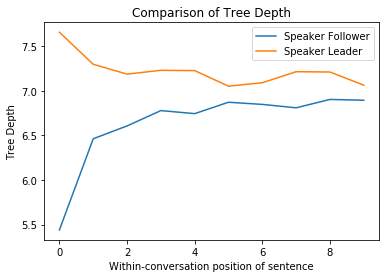

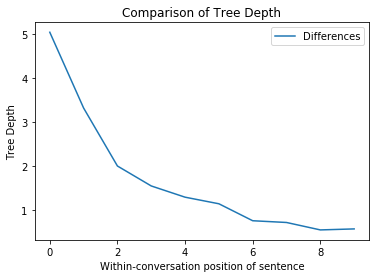

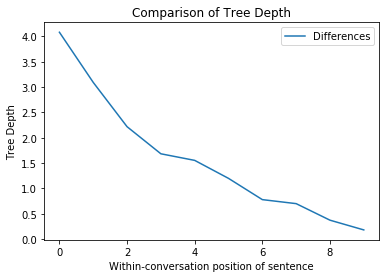

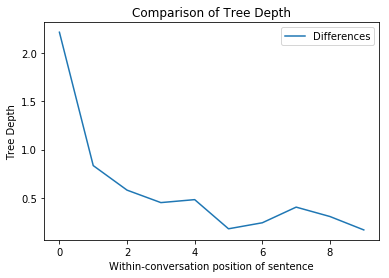

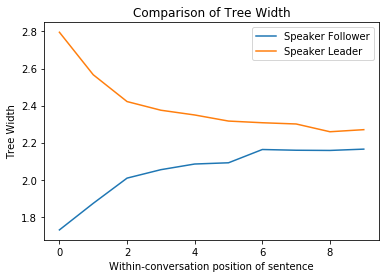

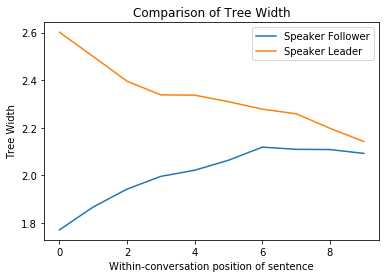

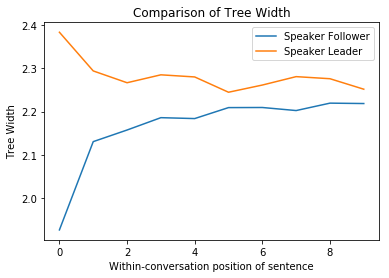

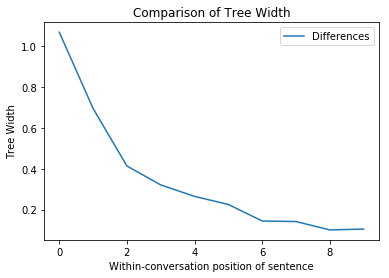

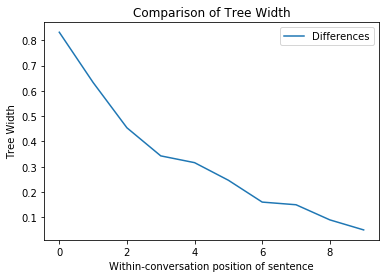

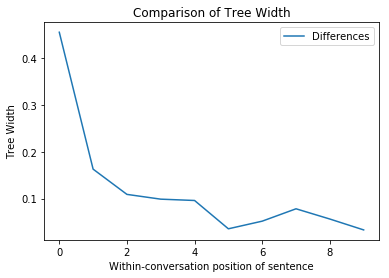

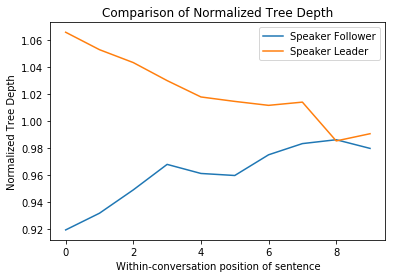

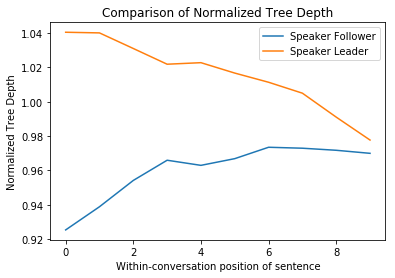

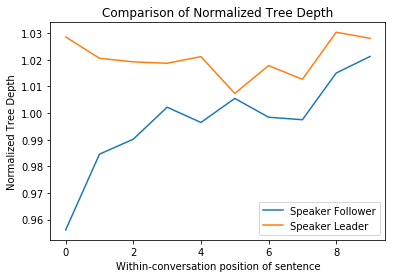

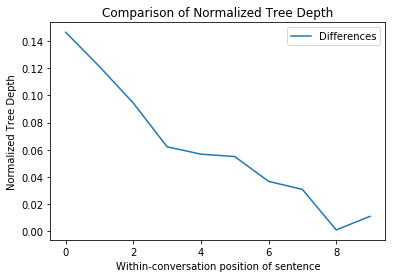

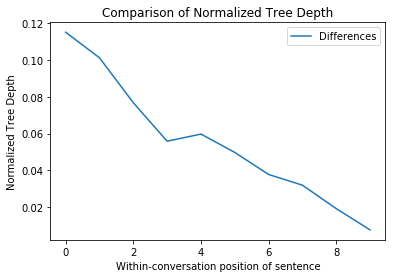

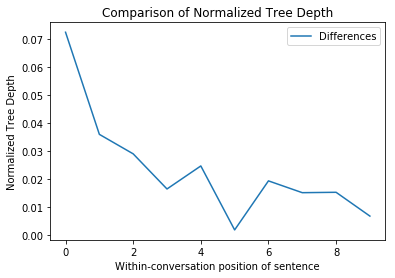

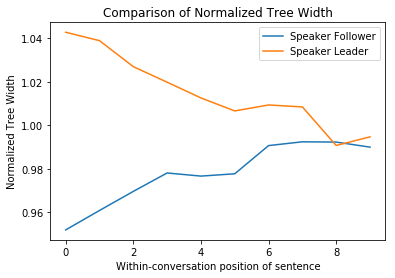

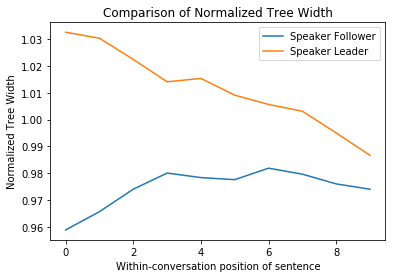

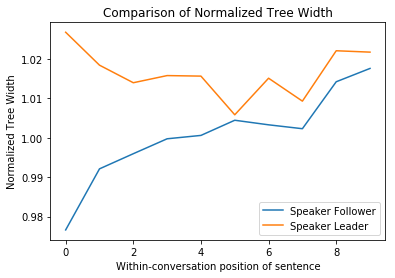

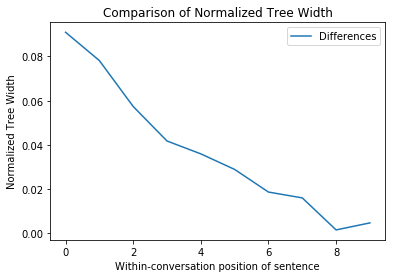

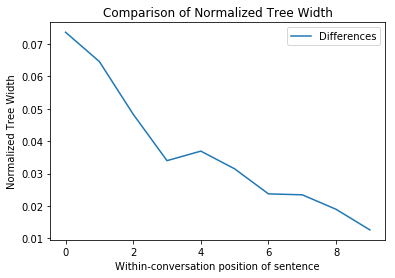

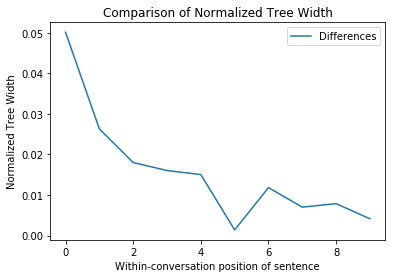

In [30]:
tt_overall_means = collect_overall_means(overall_means_tt)   
model_overall_means = collect_overall_means(overall_means_model)  
random_overall_means = collect_overall_means(overall_means_random)  
for measure in range(5):
    plot_speaker_data(tt_overall_means, measure)   
    plot_speaker_data(model_overall_means, measure)  
    plot_speaker_data(random_overall_means, measure)  
    plot_speaker_differences(tt_overall_means, measure) 
    plot_speaker_differences(model_overall_means, measure)
    plot_speaker_differences(random_overall_means, measure)

In [51]:
## Dataset collection

def get_other_speaker(this):
    if this == 'A':
        return 'B'
    else: 
        return 'A'

def is_feature_set(array):
    if np.sum(array) == 0.0: 
        return False 
    else: 
        return True

def get_features(transcript, transcript_shifts):
    init_contrib = defaultdict(lambda: np.zeros(5))
    last_contrib = defaultdict(lambda: np.zeros(5))
    current_contrib = defaultdict(lambda: np.zeros(5))
    utterance_count = defaultdict(lambda: 0)
    
    init_distance = np.zeros(5)
    last_distance = np.zeros(5)
    current_distance = np.zeros(5)
    
    init_current_diff = np.zeros(5)
    last_current_diff = np.zeros(5)
    
    features = []
    for i, utterance in enumerate(transcript):  
        utterance_features = []
        this = utterance.speaker
        other = get_other_speaker(this)
        
        if i in transcript_shifts:            
            init_contrib[this] = utterance.get_array()
            last_contrib[this] = np.zeros(5)            
            current_contrib[this] = utterance.get_array()
            utterance_count[this] = 1      
           
            init_contrib[other] = np.zeros(5)
            last_contrib[other] = np.zeros(5)
            current_contrib[other] = np.zeros(5)
            utterance_count[other] = 0
            
            init_distance = np.zeros(5) 
            last_distance = np.zeros(5) 
            current_distance = np.zeros(5) 
            
            init_current_diff = np.zeros(5)
            last_current_diff = np.zeros(5)
            
        else:
            if not is_feature_set(init_contrib[this]):
                init_contrib[this] = utterance.get_array()
            
            if is_feature_set(current_contrib[this]):
                last_contrib[this] = current_contrib[this]
            
            current_contrib[this] = utterance.get_array()
            utterance_count[this] += 1
            
            if is_feature_set(init_contrib[this]) and is_feature_set(init_contrib[other]):
                init_distance = np.abs(init_contrib[this] - init_contrib[other])
                
            if is_feature_set(last_contrib[this]) and is_feature_set(last_contrib[other]):
                last_distance = np.abs(last_contrib[this] - last_contrib[other])
                
            if is_feature_set(current_contrib[this]) and is_feature_set(current_contrib[other]):
                current_distance = np.abs(current_contrib[this] - current_contrib[other])
                
            if is_feature_set(init_distance) and is_feature_set(current_distance):
                init_current_diff = np.divide(current_distance, init_distance)
                
            if is_feature_set(last_distance) and is_feature_set(current_distance):
                last_current_diff = np.divide(current_distance, last_distance)

        if i+1 in transcript_shifts:
            label = 1
        else:
            label = 0
            
        utterance_features.extend(init_contrib[this])
        utterance_features.extend(last_contrib[this])
        utterance_features.extend(current_contrib[this])
        utterance_features.append(utterance_count[this])
        
        utterance_features.extend(init_contrib[other])
        utterance_features.extend(last_contrib[other])
        utterance_features.extend(current_contrib[other])
        utterance_features.append(utterance_count[other])
        
#         utterance_features.extend(init_distance)
#         utterance_features.extend(last_distance)
#         utterance_features.extend(current_distance)
        
#         utterance_features.extend(init_current_diff)
#         utterance_features.extend(last_current_diff)
        
        utterance_features.append(label)
        
        features.append(utterance_features)
        
    return features       

def collect_dataset(tt_topic_start_indexes, transcripts_list):
    assert len(tt_topic_start_indexes) == len(transcripts_list)
    dataset = []    
    for i in range(len(transcripts_list)):
        transcript_shifts = tt_topic_start_indexes[i]
        transcript_features = get_features(transcripts_list[i], transcript_shifts)
        dataset.extend(transcript_features)
    return dataset

In [52]:
dataset = collect_dataset(model_topic_start_indexes, transcripts_list)

/home/janosch/anaconda3/envs/tfenv2/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in divide
/home/janosch/anaconda3/envs/tfenv2/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in divide
/home/janosch/anaconda3/envs/tfenv2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in divide
/home/janosch/anaconda3/envs/tfenv2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in divide


In [53]:
headers = [
           'this_init_l', 
           'this_init_d',
           'this_init_w',
           'this_init_nd',
           'this_init_nw',
           
           'this_last_l',
           'this_last_d', 
           'this_last_w', 
           'this_last_nd', 
           'this_last_nw', 
           
           'this_current_l',
           'this_current_d',
           'this_current_w',
           'this_current_nd',
           'this_current_nw',
           
           'this_count',
           
           'other_init_l', 
           'other_init_d',
           'other_init_w',
           'other_init_nd',
           'other_init_nw',
           
           'other_last_l',
           'other_last_d', 
           'other_last_w', 
           'other_last_nd', 
           'other_last_nw', 
           
           'other_current_l',
           'other_current_d',
           'other_current_w',
           'other_current_nd',
           'other_current_nw',
           
           'other_count',
           
#            'init_distance_l',
#            'init_distance_d',
#            'init_distance_w',
#            'init_distance_nd',
#            'init_distance_nw',
           
#            'last_distance_l',
#            'last_distance_d',
#            'last_distance_w',
#            'last_distance_nd',
#            'last_distance_nw',
           
#            'current_distance_l',
#            'current_distance_d',
#            'current_distance_w',
#            'current_distance_nd',
#            'current_distance_nw',
           
#            'init_current_diff_l',
#            'init_current_diff_d',
#            'init_current_diff_w',
#            'init_current_diff_nd',
#            'init_current_diff_nw',
           
#            'last_current_diff_l',
#            'last_current_diff_d',
#            'last_current_diff_w',
#            'last_current_diff_nd',
#            'last_current_diff_nw',          
          
           'label']

df = pd.DataFrame(dataset, columns=headers)
df = df.replace([np.inf, -np.inf], 0.0)
df = df.fillna(0.0)

In [54]:
df.to_csv('dataset_5.csv', index=False)

In [35]:
def get_next_topic_break(transcript_wrapper, last_index, features, weights, threshold):
    MODEL_VERBOSE = False
    
    topic_leader = None
    for i in range(last_index+1, len(transcript_wrapper)):
        utterance = transcript_wrapper[i]
        if MODEL_VERBOSE: print(utterance.text)
        if utterance.length >= 5:
            topic_leader = utterance.speaker
            last_index = i
            break
    if not topic_leader:
        return None
    
#     print(transcript_wrapper[i].text)
#     print(transcript_wrapper[i].get_array())
    leader_measures = [transcript_wrapper[i].get_array()]
    follower_measures = []
    
    for i in range(last_index+1, len(transcript_wrapper)):
        
        if MODEL_VERBOSE: print("--- Utterance", str(i))
        utterance = transcript_wrapper[i]
#         print(i)
        if MODEL_VERBOSE: print(" ".join(transcript_wrapper[i].text))
#         print(transcript_wrapper[i].get_array())
        if utterance.length < 3: 
            continue
        if utterance.speaker == topic_leader:
            if MODEL_VERBOSE: print("Adding leader data")
            leader_measures.append(transcript_wrapper[i].get_array())
        else:
            if MODEL_VERBOSE: print("Adding follower data")
            follower_measures.append(transcript_wrapper[i].get_array())
            
        # TODO: Determine minimum topic length
        # Compare measures
        if follower_measures:
            init_distances = leader_measures[0] - follower_measures[0]
            current_distance = leader_measures[-1] - follower_measures[-1]
            
            leader_distance = leader_measures[0] - leader_measures[-1]
            follower_distance = follower_measures[0] - follower_measures[-1]
            
#             print("Current measures")
#             print(leader_measures[-1])
#             print(follower_measures[-1])
            
            if MODEL_VERBOSE: print("Distances")
            if MODEL_VERBOSE: print(init_distances)
            if MODEL_VERBOSE: print(current_distance)
#             print(leader_distance)
#             print(follower_distance)
            
            distance_development = np.divide((init_distances - current_distance), init_distances)
            leader_development = np.divide(leader_distance, leader_measures[0])
            follower_development = np.divide(follower_distance, follower_measures[0])
            
            if MODEL_VERBOSE: print("Development")
            if MODEL_VERBOSE: print(distance_development)
                
            if 1 in features:
                topic_score = np.sum(distance_development * weights)
                if MODEL_VERBOSE: print(topic_score)            
                if topic_score > threshold:
                    return i
            else:
                topic_score = np.sum(distance_development * weights)
                if MODEL_VERBOSE: print(topic_score)            
                if topic_score > threshold:
                    return i
            
    return None

def model_get_topic_start_indexes(transcript_wrapper, features, weights, threshold):
    # Determine first topic initator
    MODEL_VERBOSE = False
    
    topic_shifts = [0]
    last_index = 0  
    
    while True:
        next_shift = get_next_topic_break(transcript_wrapper, last_index, features, weights, threshold)
        
        if next_shift:
            if MODEL_VERBOSE: print("Topic shift at " + str(next_shift))
            topic_shifts.append(next_shift)
            last_index = next_shift
        else:
            break
    
                
#             print(leader_development)
#             print(follower_development)
            
#             if len(leader_measures)>3 and len(follower_measures)>3:
#                 distance_local = leader_measures[-1] - follower_measures[-1] - (np.mean(leader_measures[-4:-1] \
#                                                                                       - np.mean(follower_measures[-4:-1])))
#                 leader_local = leader_measures[-1] - np.mean(leader_measures[-4:-1])
#                 follower_local = follower_measures[-1] - np.mean(follower_measures[-4:-1])
                                                                              
#                 local_distance_development = np.divide(distance_local, leader_measures[-1] - follower_measures[-1])
#                 local_leader_development = np.divide(leader_local, leader_measures[0]) 
#                 local_follower_development = np.divide(follower_local, follower_measures[0])
                
#                 print("Local Development")
#                 print(local_distance_development)
#                 print(local_leader_development)
#                 print(local_follower_development)
#             sys.exit(1)

    if MODEL_VERBOSE: print("{} topic shifts: {}".format(len(topic_shifts), topic_shifts))
    return(topic_shifts)
            
# model_get_transcript_indexes(transcripts_list[0])
        
#     if ROLES_VERBOSE: print("Leader is {}".format(topic_leader))
#     try:
#         speaker_data['Leader'] = speaker_data.pop(topic_leader)
#     except KeyError: 
#         print(speaker_data)
#     for key in speaker_data.keys():
#         if key != 'Leader':
#             speaker_data['Follower'] = speaker_data.pop(key)

# Scratch (don't worry about errors)

In [36]:
def calculate_shift_means(overall_means):
    shift_means = []
    
    for i in range(len(overall_means)-2):
        topic_means = overall_means[i:i+2] 
#         print(len(topic_means))
        pair_means = defaultdict(lambda: defaultdict(lambda: list()))

        for topic in topic_means:
            for role, measure_dict in topic.items():
                for m, v in measure_dict.items():
                    pair_means[role][m].extend(v)

#         print(pair_means)
        for role, measure_dict in pair_means.items():
            for m, v in measure_dict.items():
                pair_means[role][m] = np.asarray(v)
            
        for role, measure_dict in pair_means.items():
            pair_means[role] = dict(measure_dict)

        shift_means.append(dict(pair_means))
#         break
        
    return shift_means

In [37]:
print(len(overall_means))

overall_cleaned = []
for mean in overall_means:
     if mean != {}: overall_cleaned.append(mean)
            
print(len(overall_cleaned))

2
2


In [38]:
shift_means = calculate_shift_means(overall_cleaned)

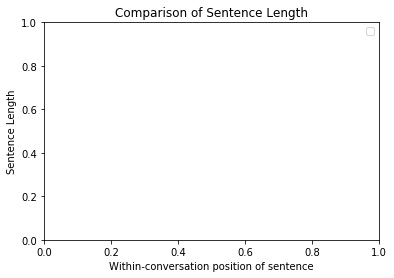

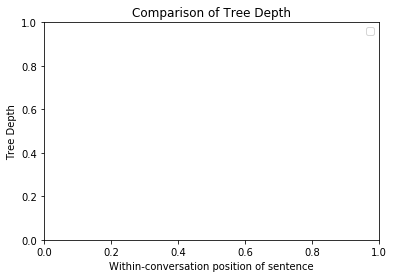

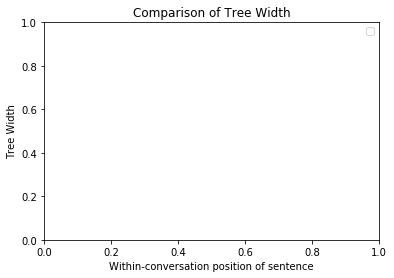

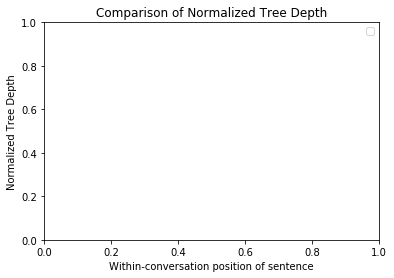

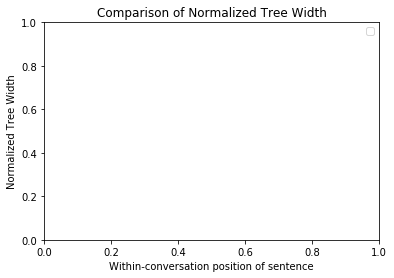

IndexError: list index out of range

In [39]:
overall_shift_means = collect_overall_means(shift_means)

for measure in range(5):
    plot_speaker_data(overall_shift_means, measure)     
for measure in range(5):
    plot_speaker_differences(overall_shift_means, measure)  

In [ ]:
topic_collection = collect_topic_data(transcript_texts, transcripts_list, collapse=False)       

In [ ]:
def calculate_shift_means2(overall_means):
    shift_means = []
    
    for transcript in overall_means:
        for i in range(len(transcript)-2):
            topic_means = transcript[i:i+2] 
    #         print(len(topic_means))
            pair_means = defaultdict(lambda: defaultdict(lambda: list()))

            for topic in topic_means:
                for role, measure_dict in topic.items():
                    for m, v in measure_dict.items():
                        pair_means[role][m].extend(v)

    #         print(pair_means)
            for role, measure_dict in pair_means.items():
                for m, v in measure_dict.items():
                    pair_means[role][m] = np.asarray(v)

            for role, measure_dict in pair_means.items():
                pair_means[role] = dict(measure_dict)

            shift_means.append(dict(pair_means))
    return shift_means

In [ ]:
shift_means2 = calculate_shift_means2(topic_collection)
print(shift_means2[0])

In [ ]:
def collect_topic_pair_means(chunk_means):
    """
    Calculates the averages over data collected in a list of speaker->measurement->measures dictionaries
    :param chunk_means: a list of speaker->measurement->measures dictionaries
    :return: a speaker->measurement->measures dictionary of averages calculated from the input list
    """
    overall_sums = defaultdict(lambda: defaultdict(lambda: list()))
    for means in chunk_means:
        chunk_sums = defaultdict(lambda: defaultdict(lambda: list()))
        for s, measures in means.items():
            for m, v in measures.items():
                chunk_sums[s][m].append(v)

    overall_means = dict()
    for s, measures in overall_sums.items():
        mean_speaker_data = dict()
        for m, data in measures.items():
            mean_speaker_data[m] = np.mean(data, axis = 0)
        overall_means[s] = mean_speaker_data
    
    return overall_means

In [ ]:
print(len(shift_means2))

In [ ]:
collected_shift_means = collect_topic_pair_means(shift_means2)
print(collected_shift_means)

for measure in range(5):
    plot_speaker_data(collected_shift_means, measure)     
for measure in range(5):
    plot_speaker_differences(collected_shift_means, measure) 